# GEOG 5160 6160 Lab 07

## Data processing

Let's start by by importing the modules we'll need for the class:

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

As before, we will start by loading and cleaning the dataset for us. There are several steps we need to take here:

- Remove observations with missing values
- Create variables containing the average number of bedrooms and rooms per district
- Create a Boolean (0/1) variable indicating whether a district is high value or not. We'll define this as being when the median house value for that district is over $250K

Now load the data and use the `describe()` method to remind us of the available variables/features

In [2]:
housing = pd.read_csv("../datafiles/housing.csv")
print(housing.shape)

(20640, 10)


In [3]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


First use the `dropna()` method to remove missing values:

In [4]:
housing = housing.dropna()
housing.shape

(20433, 10)

Next, we'll create the features with the average number of rooms and bedroom ratio.

In [5]:
housing['avg_rooms'] = housing.total_rooms / housing.households
housing['bedroom_ratio'] = housing.total_bedrooms / housing.total_rooms

Now, we'll create two categorical features for use in the model, both binary. For the first of these, we'll convert the `ocean_proximity` feature into a binary value. This requires a few steps: first we convert this to two groups by with a conditional statement (INLAND vs all other locations); then we convert this to a categorical Series and extract the numerical codes (0/1) using `.cat.codes`. 

In [6]:
ocean_cats = housing.ocean_proximity != "INLAND" ## Conditional to make two groups inland vs all others
ocean_cats = ocean_cats.astype('category') ## Convert to categorical
ocean_cats = ocean_cats.cat.codes ## Extract the code numerical labels (0/1)
housing['ocean_new'] = ocean_cats ## Replace original ocean_proximity

Next we convert the `median_house_value` to a binary outcome of low vs. high house values. Here we use Pandas `cut()` function. For $k$ groups, this requires a vector of cuts of length $k+1$, and optionally a vector of labels for the new groups of length $k$. 

In [7]:
bins = [0, 2.5e5, np.inf]
labels = ['low', 'high']
housing['mhv_new'] = pd.cut(housing.median_house_value, bins, labels = labels)

Now let's look at the new data

In [8]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,avg_rooms,bedroom_ratio,ocean_new,mhv_new
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,0.146591,1,high
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.155797,1,high
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,0.129516,1,high
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,0.184458,1,high
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,0.172096,1,high


We can make a quick barplot to show the distribution of our house value categories. This suggests that the data are unbalanced, with more observations in the low than in the high category. We'll want to account for this when designing resampling strategies. 

<AxesSubplot:xlabel='mhv_new', ylabel='count'>

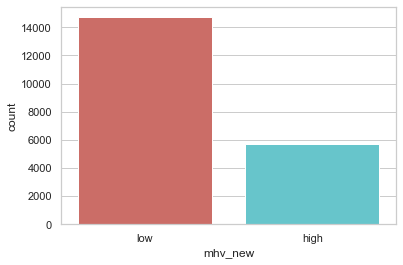

In [9]:
sns.countplot(x="mhv_new", data=housing, palette='hls')

Centering

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,avg_rooms,bedroom_ratio,ocean_new
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155,5.431344,0.213039,0.682083
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099,2.482946,0.057983,0.465678
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000,4.441441,0.175427,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000,5.230769,0.203162,1.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000,6.052381,0.239821,1.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1.000000


Boxplots

## Features and labels

Let's make new DataFrames: one with a subset of variables or features for building our initial model, and one with the outcome or labels. We're going to center the continuous variables, so we have to a little more work here than previously. There are a couple of ways to do this, and we'll go through both of them here. 

In the first method:

- We first extract the subset of variables in to a new DataFrame `X`. 
- Then we take advantage of Pandas `mean()` method to subtract the columns means from each column. 
- As this also removes the mean from the binary variable representing proximity to ocean (`ocean_new`), we replace it with the original value from the `housing` DataFrame. 

If we now look at the summary of the data, you should see that the mean of all numeric variables is 0 (or close to it). 

In [11]:
X = housing[['avg_rooms', 'bedroom_ratio', 'housing_median_age', 'median_income', 
             'population', 'ocean_new']]
X_scaled = X - X.mean()
X_scaled.ocean_new = housing.ocean_new
X_scaled.describe()

,avg_rooms,bedroom_ratio,housing_median_age,median_income,population,ocean_new
count,2.043300e+04,2.043300e+04,20433.000000,2.043300e+04,2.043300e+04,20433.000000
mean,-1.669165e-17,1.390971e-17,0.000000,6.008995e-16,-9.685609e-14,0.682083
std,2.482946e+00,5.798267e-02,12.591805,1.899291e+00,1.133208e+03,0.465678
min,-4.585190e+00,-1.130388e-01,-27.633094,-3.371262e+00,-1.421947e+03,0.000000
25%,-9.899025e-01,-3.761145e-02,-10.633094,-1.307462e+00,-6.379469e+02,0.000000
50%,-2.005747e-01,-9.876396e-03,0.366906,-3.346616e-01,-2.589469e+02,1.000000
75%,6.210370e-01,2.678186e-02,8.366906,8.728384e-01,2.970531e+02,1.000000
max,1.364777e+02,7.869612e-01,23.366906,1.112894e+01,3.425705e+04,1.000000


A second way to do this transformation is by using scikit-learn's preprocessing toolkit (called, not surprisingly, `preprocessing`).  

- Import the `StandarScaler` function from `preprocessing
- Create an array of column names
- Use this to create a subset of the original features from `housing` into a new matrix `X`
- Create an object `scaler` using `StandardScaler()`. This is an object that holds information about the type of transformation we want to do. By default, this method will standardized numeric variables by first subtracting the mean, then dividing by the standard deviation. The argument `with_std=False` stops this second step. 
- Once this is set up, we use the `fit()` method to apply this to `X`. As this requires a NumPy array, rather than a Pandas DataFrame, we apply it to the `values()` of `X`
- We then back convert this to a Pandas DataFrame (and use the `col_names` array to set the column names)
- Finally we add the `ocean_new` column to our new scaled DataFrame. To allow us to copy the values directly over from one DataFrame to another, we first have to make sure the indices align. The easiest way to do this is to simply copy the `housing` index to the `X_scaled` index 

This is obviously more work than the first way, but it allows a much wider range of data transformations that will be useful with some other methods. 

In [12]:
from sklearn.preprocessing import StandardScaler
col_names = ['avg_rooms', 'bedroom_ratio', 'housing_median_age', 'median_income', 
             'population', 'ocean_new']
X = housing[col_names]
scaler = StandardScaler(with_std=False).fit(X.values)
X_scaled = pd.DataFrame(scaler.transform(X.values), columns = col_names)
X_scaled.index = housing.index
X_scaled['ocean_new'] = housing.ocean_new

We also need to create our array of labels (the `mhv_new` variable created earlier):

NEEDS EDITING

In [13]:
mhv_dummies = pd.get_dummies(housing.mhv_new)
print(mhv_dummies)
y = mhv_dummies.high
print(y)

       low  high
0        0     1
1        0     1
2        0     1
3        0     1
4        0     1
...    ...   ...
20635    1     0
20636    1     0
20637    1     0
20638    1     0
20639    1     0

[20433 rows x 2 columns]
0        1
1        1
2        1
3        1
4        1
        ..
20635    0
20636    0
20637    0
20638    0
20639    0
Name: high, Length: 20433, dtype: uint8


## Training/test split

We'll set up a couple of different strategies for testing our models. First, a holdout method with 80% of the data in the training set (this will be used for initial tests). As we noted previously that the data are unbalanced with more 'low' value districts than 'high' value ones, we use the argument `stratify` to do, well, stratified sampling. This will force the training and testing datasets to have the same proportion of low and high value districts as in the full dataset. 

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    train_size = 0.8,
                                                    stratify = y)

Next, a 5-fold cross-validation strategy (this will be used to get the final estimate of model skill). Unlike the previous lab, we use the stratified version of $K$-fold cross-validation to keep the proportions of low/high value districts consistent across all folds. 

In [15]:
from sklearn.model_selection import StratifiedKFold
# define model evaluation method
cv = StratifiedKFold(n_splits=5)

## Logistic regression

Now we've set up our training and testing sets, we can build the model. The function for logistic regression is part of the linear model methods in scikit-learn, so import this, and create a new logistic regression object. This uses an optimization routine to find the best estimate of the coefficients, and works best for small datasets. To make sure this will fit our model, we increase the maximum number of iterations for the optimizer (you could alternatively try different optimizers or transformations of the data).

In [16]:
from sklearn import linear_model
log_reg = linear_model.LogisticRegression(max_iter=200)

Now let's use the training data to fit it:

In [17]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=200)

As before, we can look at the coefficients from this model:

In [18]:
cdf = pd.DataFrame(log_reg.coef_.transpose(), X_train.columns, columns=['Coefficients'])
print(cdf)

                    Coefficients
avg_rooms               0.061525
bedroom_ratio           8.838892
housing_median_age      0.036852
median_income           1.193741
population              0.000003
ocean_new               1.942674


And the intercept:

In [19]:
print(log_reg.intercept_)

[-2.87961422]


### Predicting with the test set

Next step is to predict the the value of `mhv_new` for for the testing set. 

In [20]:
y_test_pred = log_reg.predict(X_test)
print(y_test_pred)

[0 0 0 ... 0 0 0]


In [21]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2943
           1       0.77      0.59      0.67      1144

    accuracy                           0.84      4087
   macro avg       0.81      0.76      0.78      4087
weighted avg       0.83      0.84      0.83      4087



In [22]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
print(cm)

[[2745  198]
 [ 472  672]]


First column is probability of a '0' or a low value district, second column is probability of a '1' or high value district. 

In [23]:
y_test_pred = log_reg.predict_proba(X_test)
print(y_test_pred)

[[0.98804231 0.01195769]
 [0.98918409 0.01081591]
 [0.98711669 0.01288331]
 ...
 [0.99688843 0.00311157]
 [0.97200647 0.02799353]
 [0.86867441 0.13132559]]


ROC curve

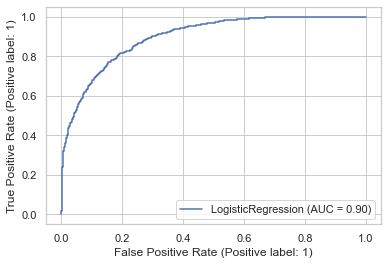

In [24]:
metrics.plot_roc_curve(log_reg, X_test, y_test) 

In [25]:
metrics.roc_auc_score(y_test, y_test_pred[:,1])

0.8969547272299567

The optimal cut off point would be where true positive rate is high and the false positive rate is low. Calculate these directly

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred[:,1])
thresholds[np.argmax(tpr - fpr)]

0.28809204464500604

Cross validation

In [27]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
# define model evaluation method
cv = StratifiedKFold(n_splits=5)

scores = cross_val_score(log_reg, X, y, cv=cv, scoring = 'roc_auc')

In [28]:
with np.printoptions(precision=3, suppress=True):
    print(scores)
print("%.3f" % np.mean(scores))

[0.882 0.819 0.844 0.912 0.897]
0.871


## Naive Bayes

In [29]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [30]:
scores = cross_val_score(gnb, X, y, cv=cv, scoring = 'roc_auc')
with np.printoptions(precision=3, suppress=True):
    print(scores)
print("%.3f" % np.mean(scores))

[0.867 0.735 0.836 0.872 0.899]
0.842


## Support vector machine

Need to scale features for SVM

In [31]:
scaler = StandardScaler(with_std=True).fit(X.values)
X_scaled = pd.DataFrame(scaler.transform(X.values), columns = col_names)
X_scaled.index = housing.index
X_scaled['ocean_new'] = housing.ocean_new

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    train_size = 0.8,
                                                    stratify = y)

In [33]:
from sklearn import svm
linear_svc = svm.SVC(kernel='linear')
linear_svc.fit(X_train, y_train)

SVC(kernel='linear')

In [34]:
scores = cross_val_score(linear_svc, X_scaled, y, cv=cv, scoring = 'roc_auc')
with np.printoptions(precision=3, suppress=True):
    print(scores)
print("%.3f" % np.mean(scores))

[0.911 0.843 0.861 0.905 0.898]
0.884


In [35]:
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.fit(X_train, y_train)

SVC()

In [36]:
scores = cross_val_score(rbf_svc, X_scaled, y, cv=cv, scoring = 'roc_auc')
with np.printoptions(precision=3, suppress=True):
    print(scores)
print("%.3f" % np.mean(scores))

[0.895 0.821 0.856 0.879 0.874]
0.865
